In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# Feature exploration

Let's explore features that have a high cardinality and find a way to reduce it. <br>

In [2]:
df_tr = pd.read_csv('train.csv')
df_tr.fillna(-1,inplace=True)

/home/dlo/anaconda3/envs/fastai_gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_tr.columns

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
       'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode',
       'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_ProcessorClass',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_

In [3]:
df_te = pd.read_csv('test.csv')
df_te.fillna(-1,inplace=True)

In [4]:
df_tr['HasDetections'].mean()

0.49979269141688665

The dataset is balanced. Let's check for very high cardinality feats

In [4]:
n_un = df_tr.nunique()
n_un[n_un > 2500]

MachineIdentifier                        8921483
AvSigVersion                                8531
AVProductStatesIdentifier                  28970
CityIdentifier                            107366
Census_OEMNameIdentifier                    3832
Census_OEMModelIdentifier                 175365
Census_ProcessorModelIdentifier             3428
Census_PrimaryDiskTotalCapacity             5735
Census_SystemVolumeTotalCapacity          536848
Census_TotalPhysicalRAM                     3446
Census_InternalBatteryNumberOfCharges      41088
Census_FirmwareVersionIdentifier           50494
dtype: int64

In [5]:
list(n_un[n_un > 2500].index)

['MachineIdentifier',
 'AvSigVersion',
 'AVProductStatesIdentifier',
 'CityIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalBatteryNumberOfCharges',
 'Census_FirmwareVersionIdentifier']

## Let's go over high cardinality feats and decide what to do with them.

For columns that have a too high cardinality, the easiest thing to do is to encode individually only values that appear often in the data, and give a unique category "uncommon IDs" to the rest. <br>
If possible we can do more sophisticated feature engineering, but let's try not to.

In [5]:
smalldf = df_tr.sample(200000)

In [16]:
smallte = df_te.sample(200000)

### MachineIdentifier is the index, np. <br>
### AvSigVersion:

In [7]:
smalldf['AvSigVersion'].head()

4483958    1.273.1565.0
46282        1.277.23.0
7792929     1.249.872.0
7258190     1.271.514.0
8713147    1.273.1749.0
Name: AvSigVersion, dtype: object

Cut it on dots

In [6]:
import re
splitter = lambda x : x.split(".")
splitted_sig = pd.DataFrame([splitter(o) for o in smalldf['AvSigVersion'].values])
splitted_sig.head()

,0,1,2,3
0,1,275,1075,0
1,1,273,950,0
2,1,275,836,0
3,1,275,727,0
4,1,273,1167,0


In [9]:
split_te = pd.DataFrame([splitter(o) for o in smallte['AvSigVersion'].values])
split_te.head()

,0,1,2,3
0,1,277,717,0
1,1,277,176,0
2,1,279,646,0
3,1,277,204,0
4,1,279,1626,0


Shit the test and train set dont have the same antivirus signatures, cant use the feature like that

In [10]:
splitted_sig.nunique() #number of unique values per column

0       2
1      35
2    1993
3       1
dtype: int64

In [11]:
"""
Index (on the left) is column 1 from split signatures.
The lists on the right are all the possible values taken by column 2, sorted,
when column 1 takes the value from the index. 
So when splitted_sig[1] == 213, splitted_sig[2] can take the value 2626, 7751
"""

splitted_sig[[1,2]].groupby(1)[2].apply(set).apply(lambda x : sorted([int(o) for o in x]))

1
0                                                    [0]
199                                               [1615]
201                                               [2151]
207                                         [1186, 2950]
213                                         [2626, 7751]
217                                               [1446]
221                                                 [14]
223    [834, 927, 992, 1159, 1370, 1473, 1665, 1709, ...
225    [35, 145, 160, 237, 255, 264, 323, 394, 412, 4...
227    [29, 120, 179, 202, 254, 359, 370, 376, 408, 4...
229    [18, 35, 68, 111, 172, 210, 232, 252, 259, 327...
231    [12, 31, 55, 66, 103, 129, 137, 151, 192, 224,...
233    [14, 71, 112, 119, 154, 155, 165, 177, 202, 21...
235    [39, 53, 70, 126, 133, 149, 163, 174, 182, 224...
237    [0, 11, 30, 42, 47, 52, 58, 72, 77, 128, 134, ...
239    [31, 37, 76, 92, 104, 126, 131, 135, 151, 171,...
241    [4, 35, 41, 72, 117, 120, 157, 188, 229, 234, ...
243    [0, 3, 10, 39, 52, 69,

In [12]:
split_te[[1,2]].groupby(1)[2].apply(set).apply(lambda x : sorted([int(o) for o in x]))

1
0                                                    [0]
199                                               [1615]
207                                               [2950]
211                                               [1747]
213                                                [134]
219                                               [1665]
221                                                 [14]
223    [649, 850, 1333, 1384, 1414, 1538, 1597, 1640,...
225    [48, 101, 164, 191, 241, 306, 345, 433, 462, 4...
227    [54, 59, 76, 113, 283, 313, 349, 354, 394, 512...
229    [35, 59, 120, 122, 138, 163, 259, 287, 313, 36...
231    [111, 175, 189, 195, 206, 216, 327, 353, 385, ...
233    [38, 46, 86, 112, 119, 126, 172, 194, 216, 245...
235    [53, 70, 156, 182, 195, 238, 329, 397, 415, 42...
237    [0, 32, 47, 58, 77, 185, 196, 262, 290, 305, 3...
239    [31, 37, 64, 76, 92, 122, 129, 139, 178, 194, ...
241    [4, 35, 72, 166, 183, 188, 206, 217, 234, 257,...
243    [10, 74, 80, 92, 98, 1

Test & train really don't have the same av signatures. Can't use them as integer categories, as categories from the test set won't be known by the NN. We could encode them as NaN but we'll lose a lot of info. <br>
Or we could encode them as real numbers and normalize them with 0 mean 1 std but not sure how to give them an ordering that makes sense. <br>
We could do a "av signature radix" and decompose av signatures into <br>
$$ signature_0 * base_0 + signature_1 * base_1 + signature_2 * base_2 + signature_3 * base_3 $$
as is done with radix 2 for binary and radix 10 for decimal, but even like that i'm not sure we can reliably determine base2 for example, i.e. know when they decide that version 0.0.X.Y is going to 0.A.0.0 and not 0.0.X.Z. <br>
Or maybe we can just take it easy and drop all columns except column 1, this one seems to grow kind of regularly, up to 277 in the sampled train set and up to 281 in the sampled test set. We could just divide this column by 300, remove its mean and basta. <br>
Let's try version 2 for the moment


In [7]:
tr = pd.DataFrame([splitter(o) for o in df_tr['AvSigVersion'].values])

In [8]:
tr = tr[2].astype('float32')
tr = tr - tr.mean()
tr = tr/tr.std()
df_tr['AvSigVersion'] = tr

In [10]:
te = pd.DataFrame([splitter(o) for o in df_te['AvSigVersion'].values])

In [11]:
"""
In nearly all cases we should normalize the test set with
the mean and std from the train set, but here we actually want
to normalize separately so that the test set's first avsig 
has value 0
"""
te = te[2].astype('float32')
te = (te - te.mean())/te.std()
df_te['AvSigVersion'] = te

### AVProductStatesIdentifier:

In [13]:
smalldf['AVProductStatesIdentifier'].head()

908438     53447.0
5641020    53447.0
7329451    53447.0
2321050    53447.0
8047708    53447.0
Name: AVProductStatesIdentifier, dtype: float64

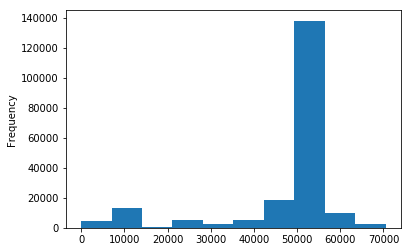

In [14]:
smalldf['AVProductStatesIdentifier'].plot.hist()

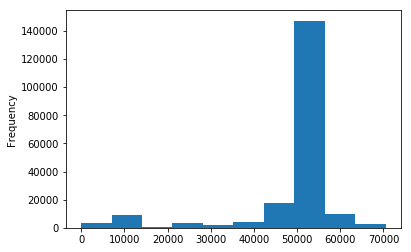

In [17]:
smallte['AVProductStatesIdentifier'].plot.hist()

In [18]:
len(list(set(df_te['AVProductStatesIdentifier']).difference(set(df_tr['AVProductStatesIdentifier']))))

10861

Hmm 10k categories from the test set are not covered in the train set that's not good. Let's see how many data points that represents if we encode only the 500 most common from the train set, and only examples with > 30 occurences

In [21]:
def get_col_enc_dict(c) :
    """
    Takes as input c, a pd.Series.
    Counts uniques values in c
    Creates a list of values that have at least 10 occurences in c.
    The first element in the list is the most frequent element in c, etc.
    Keeps the first 500 elements, store it in most_comm_vals
    Returns a dict mapping the most 500 frequent values to their position (+1)
    in the list. To be used to int encode c.
    """
    ct = Counter(c)
    most_comm_vals = [k for k,v in ct.most_common() if ((v > 30) & (k != -1))][:500]
    most_comm_dict = {k : v+1 for v,k in enumerate(most_comm_vals)}
    most_comm_dict[-1] = -1
    return most_comm_dict

def enc_col(col,d = None) :
    """
    Elements of that c are in d are mapped to their values in d
    Elements not in c and are not NaNs are mapped to 0
    NaNs were mapped to -1 at the beginning of the notebook and
    are kept to -1
    """
    c = col.copy()
    if d is None : d = get_col_enc_dict(c)
    in_keys = c.isin(d.keys())
    c.loc[in_keys] = c.map(d)
    c.loc[~in_keys] = 0
    return c,d

In [23]:
tr, dict_av_id = enc_col(df_tr['AVProductStatesIdentifier'])
te, _ = enc_col(df_te['AVProductStatesIdentifier'],dict_av_id)

In [18]:
(tr == 0).sum()/tr.shape[0]

0.022095205472005046

In [19]:
(te == 0).sum()/te.shape[0]

0.019853556226954613

Ok that should be fine, approx 2% of the dataset won't have unique labels, and are given the "bucket label" 0 of uncommon values

### CityIdentifier:

In [20]:
smalldf['CityIdentifier'].head()

1558012     34946.0
4032551     70124.0
421110      35169.0
6534122     48582.0
2692332    120008.0
Name: CityIdentifier, dtype: float64

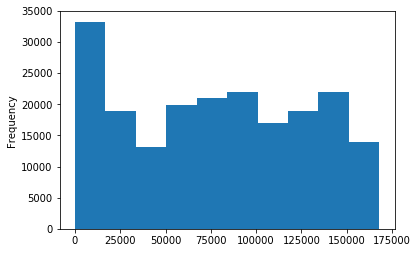

In [21]:
smalldf['CityIdentifier'].plot.hist()

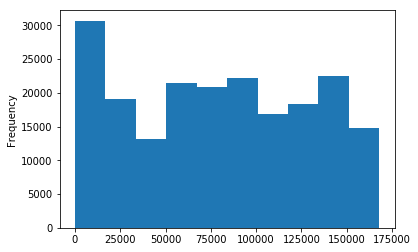

In [22]:
smallte['CityIdentifier'].plot.hist()

In [27]:
tr, dict_city_id = enc_col(df_tr['CityIdentifier'])
te, _ = enc_col(df_te['CityIdentifier'],dict_city_id)

In [28]:
(tr == 0).sum()/8921483

0.41765276019693137

That's not good, 42% of the cities have been removed. That was expected given the nearly uniform distribution over cities seen in the above plot... need better encoding

In [22]:
def get_col_enc_dict_nosizelimit(c) :

    ct = Counter(c)
    most_comm_vals = [k for k,v in ct.most_common() if ((v > 100) & (k != -1))]
    most_comm_dict = {k : v+1 for v,k in enumerate(most_comm_vals)}
    most_comm_dict[-1] = -1
    return most_comm_dict

def enc_col_nosizelimit(col,d = None) :

    c = col.copy()
    if d is None : d = get_col_enc_dict_nosizelimit(c)
    in_keys = c.isin(d.keys())
    c.loc[in_keys] = c.map(d)
    c.loc[~in_keys] = 0
    return c,d

In [127]:
tr, dict_city_id = enc_col_nosizelimit(df_tr['CityIdentifier'])

In [128]:
tr[tr == 0].shape[0]/df_tr.shape[0], len(dict_city_id)

(0.1148569133629465, 6961)

Ok now 11% of cities are not covered but we have 7k categories, its a lot but let's deal with it

### Census_OEMNameIdentifier :

In [131]:
smalldf['Census_OEMNameIdentifier'].head()

908438     4142.0
5641020     525.0
7329451    3035.0
2321050    3035.0
8047708     585.0
Name: Census_OEMNameIdentifier, dtype: float64

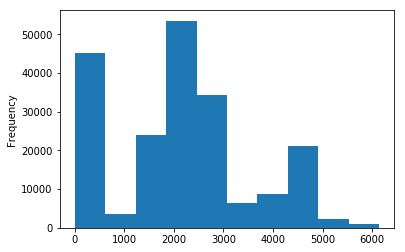

In [132]:
smalldf['Census_OEMNameIdentifier'].plot.hist()

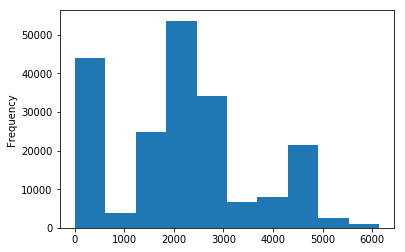

In [133]:
smallte['Census_OEMNameIdentifier'].plot.hist()

In [134]:
smalldf['Census_OEMNameIdentifier'].head(15)

908438     4142.0
5641020     525.0
7329451    3035.0
2321050    3035.0
8047708     585.0
5009368    1443.0
938081     4730.0
8409031    1443.0
8799750    2102.0
5304663    4589.0
5636351    4142.0
4663479     525.0
4021695    2436.0
6252442     585.0
5466622    1980.0
Name: Census_OEMNameIdentifier, dtype: float64

In [135]:
len(list(set(df_te['Census_OEMNameIdentifier']).difference(set(df_tr['Census_OEMNameIdentifier']))))

809

In [136]:
feat = 'Census_OEMNameIdentifier'
tr, d = enc_col(df_tr[feat])
te, _ = enc_col(df_te[feat],d)

In [137]:
(tr == 0).sum()/8921483, (te == 0).sum()/7853253

(0.005121570034937017, 0.005334477317870697)

Perfect, less than 0.6% of the data in the bucket category of 0

### Census_OEMModelIdentifier :

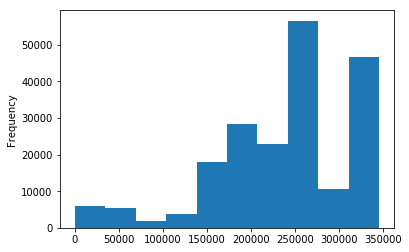

In [138]:
smalldf['Census_OEMModelIdentifier'].plot.hist()

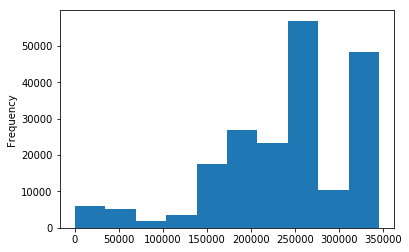

In [139]:
smallte['Census_OEMModelIdentifier'].plot.hist()

In [140]:
feat = 'Census_OEMModelIdentifier'
tr, d = enc_col(df_tr[feat])
te, _ = enc_col(df_te[feat],d)
(tr == 0).sum()/8921483, (te == 0).sum()/7853253

(0.47855440625734535, 0.4889990173498804)

Not good, let's try the other encoder

In [142]:

tr, d = enc_col_nosizelimit(df_tr[feat])
te, _ = enc_col_nosizelimit(df_te[feat],d)
(tr == 0).sum()/8921483, (te == 0).sum()/7853253, len(d)

(0.11205166226287715, 0.11495974980049668, 7140)

7k categories again, let's deal with it

### Census_ProcessorModelIdentifier :

In [26]:
smalldf['Census_ProcessorModelIdentifier'].unique()

array([3521., 3394., 1992., ...,  389.,  828., 4107.])

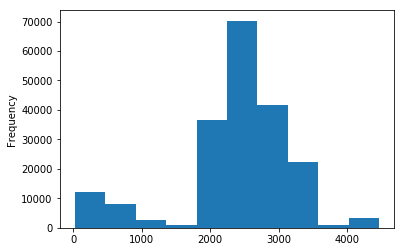

In [27]:
smalldf['Census_ProcessorModelIdentifier'].plot.hist()

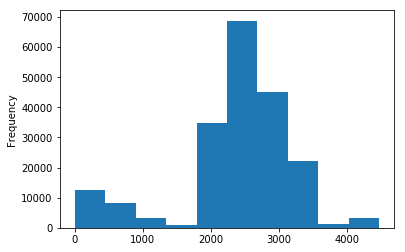

In [147]:
smallte['Census_ProcessorModelIdentifier'].plot.hist()

In [148]:
feat = 'Census_ProcessorModelIdentifier'
tr, d = enc_col(df_tr[feat])
te, _ = enc_col(df_te[feat],d)
(tr == 0).sum()/8921483, (te == 0).sum()/7853253

(0.07304054718257043, 0.07750953649398536)

Good

### Census_PrimaryDiskTotalCapacity
Not an Identifier for once, maybe there's some feature engineering to do

In [186]:
ser = df_tr['Census_PrimaryDiskTotalCapacity'].copy()


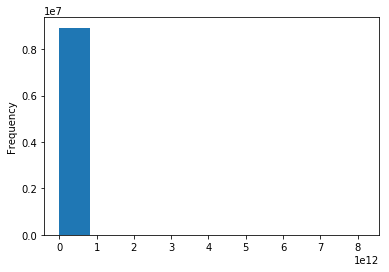

In [187]:
ser.plot.hist()

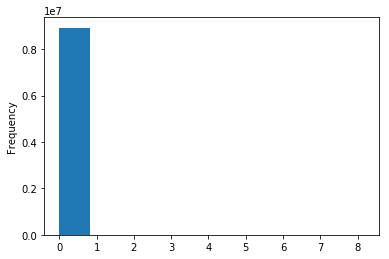

In [189]:
(ser/1e12).plot.hist()

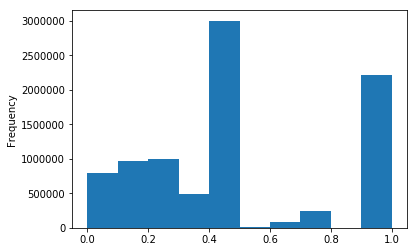

In [190]:
(ser[ser < 1e6]/1e6).plot.hist()

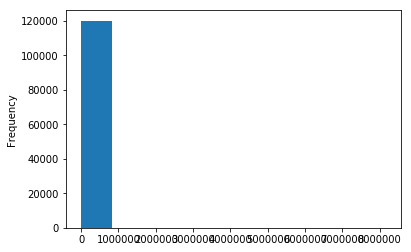

In [191]:
(ser[ser > 1e6]/1e6).plot.hist()

In [192]:
ser.min(),ser.max()

(-1.0, 8160436745562.0)

In [193]:
logser = np.log2(ser + 1.5)
logser.head()

0    18.863453
1    18.863453
2    16.804667
3    17.863488
4    18.863453
Name: Census_PrimaryDiskTotalCapacity, dtype: float64

Disk capacity is not a power of 2, but let's use it to make it categories

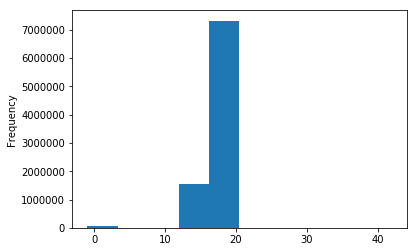

In [196]:
logser = np.log2(ser + 1.5).astype(int)
logser.plot.hist()

In [197]:
s_ = [-1,0,0.5,1,2**10, 2**16]
logser = np.log2([o + 1.5 for o in s_])
pd.DataFrame(logser).astype(int)

,0
0,-1
1,0
2,1
3,1
4,10
5,16


That's perfect, take int of log2 of the disk size and get meaningful categories. NaNs and 0 have kept their category

### Census_SystemVolumeTotalCapacity

In [4]:
ser = df_tr['Census_SystemVolumeTotalCapacity'].copy()
ser.head()

0    299451.0
1    102385.0
2    113907.0
3    227116.0
4    101900.0
Name: Census_SystemVolumeTotalCapacity, dtype: float64

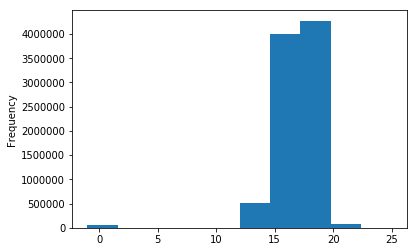

In [5]:
logser = np.log2(ser + 1.5).astype(int)
logser.plot.hist()

Good, same as before. Log2, to int, get meaningful categories

### Census_TotalPhysicalRAM :

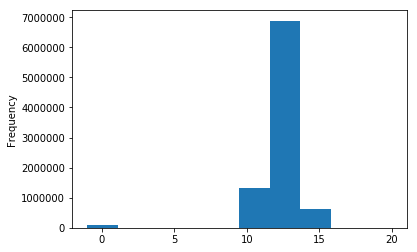

In [7]:
ser = df_tr['Census_TotalPhysicalRAM'].copy()
logser = np.log2(ser + 1.5).astype(int)
logser.plot.hist()

Same, int(log2(feat)) = meaningful cats

### Census_InternalBatteryNumberOfCharges

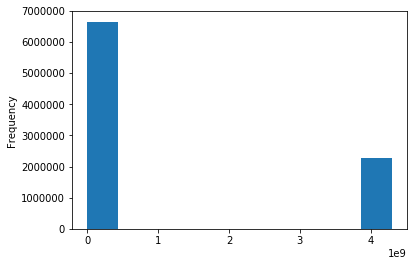

In [8]:
df_tr['Census_InternalBatteryNumberOfCharges'].plot.hist()

In [9]:
ser = df_tr['Census_InternalBatteryNumberOfCharges'].copy()


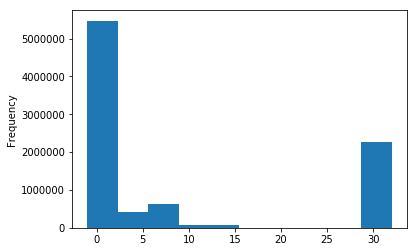

In [17]:
logser = np.log2(ser + 1.5).astype(int)
logser.plot.hist()

### Census_FirmwareVersionIdentifier :

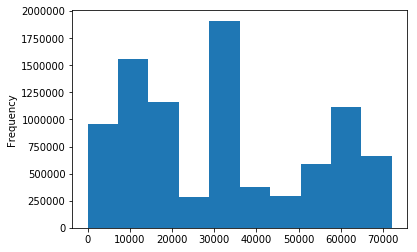

In [20]:
df_tr['Census_FirmwareVersionIdentifier'].plot.hist()

In [27]:
df_tr['Census_FirmwareVersionIdentifier'].head()

0    36144.0
1    57858.0
2    52682.0
3    20050.0
4    19844.0
Name: Census_FirmwareVersionIdentifier, dtype: float64

In [24]:
df_te = pd.read_csv('test.csv',usecols = ['Census_FirmwareVersionIdentifier'])

In [25]:
feat = 'Census_FirmwareVersionIdentifier'
tr, d = enc_col(df_tr[feat])
te, _ = enc_col(df_te[feat],d)
(tr == 0).sum()/8921483, (te == 0).sum()/7853253

(0.4168445985942023, 0.45183403616310336)

Not good

In [26]:
tr, d = enc_col_nosizelimit(df_tr[feat])
te, _ = enc_col_nosizelimit(df_te[feat],d)
(tr == 0).sum()/8921483, (te == 0).sum()/7853253

(0.06986394526560215, 0.10090315439983914)

Better, not very good as the train and test set dont have the same distribution of unknown. <br>
That was it for high cardinality feats.

In [34]:
df_tr.columns

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
       'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode',
       'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_ProcessorClass',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_

Still a few columns with "Version" or something, need to check if special encoding is needed

In [35]:
df_tr[[o for o in df_tr.columns if "Ver" in o]].head()

,EngineVersion,AppVersion,AvSigVersion,OsVer,IeVerIdentifier,Census_InternalPrimaryDisplayResolutionVertical,Census_OSVersion,Census_FirmwareVersionIdentifier
0,1.1.15100.1,4.18.1807.18075,1.273.1735.0,10.0.0.0,137.0,900.0,10.0.17134.165,36144.0
1,1.1.14600.4,4.13.17134.1,1.263.48.0,10.0.0.0,137.0,768.0,10.0.17134.1,57858.0
2,1.1.15100.1,4.18.1807.18075,1.273.1341.0,10.0.0.0,137.0,1080.0,10.0.17134.165,52682.0
3,1.1.15100.1,4.18.1807.18075,1.273.1527.0,10.0.0.0,137.0,768.0,10.0.17134.228,20050.0
4,1.1.15100.1,4.18.1807.18075,1.273.1379.0,10.0.0.0,137.0,768.0,10.0.17134.191,19844.0


Probably than some of them need to be cut and encoded as avsigversion